In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, ShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import time

In [2]:
# Importing the dataset
traindata = pd.read_csv("data/train.csv")
#testdata = pd.read_csv('data/test.csv')

In [3]:
traindata = traindata.dropna()
print(traindata.shape)

(404287, 6)


In [4]:
np.isnan(traindata.any())

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [5]:
traindata.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
labels = np.array(traindata["is_duplicate"])

In [7]:
features = pd.read_csv("data/train_set3_features.csv")

In [8]:
features.head()

,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,total_unique_word_num,total_unique_word_withoutstopword_num,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
0,65,56,14,12,26,2,1,0,12,6,...,5.081614,1.0,94.023324,0.371408,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301
1,48,85,10,15,25,5,1,0,17,11,...,11.028160,1.0,158.811137,0.785732,0.353440,0.437108,0.004801,0.163020,0.185670,0.112646
2,70,54,14,10,24,4,1,0,19,8,...,8.829532,1.0,131.681688,0.635757,0.286115,0.329345,0.226704,0.060504,0.089026,-0.465365
3,48,58,11,13,24,2,0,0,20,9,...,16.075622,1.0,195.966982,1.151438,0.513992,0.708427,-0.002527,0.009567,-0.244560,0.074111
4,73,38,13,7,20,6,1,0,16,13,...,12.103178,1.0,161.408435,0.860225,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876


In [9]:
features.shape

(404287, 41)

In [10]:
np.isnan(features.all())

q1_char_num                              False
q2_char_num                              False
q1_word_num                              False
q2_word_num                              False
total_word_num                           False
differ_word_num                          False
same_first_word                          False
same_last_word                           False
total_unique_word_num                    False
total_unique_word_withoutstopword_num    False
total_unique_word_num_ratio              False
common_word_num                          False
common_word_ratio                        False
common_word_ratio_min                    False
common_word_ratio_max                    False
common_word_withoutstopword_num          False
common_word_withoutstopword_ratio        False
common_word_withoutstopword_ratio_min    False
common_word_withoutstopword_ratio_max    False
fuzz_ratio                               False
fuzz_QRatio                              False
fuzz_WRatio  

In [11]:
np.isfinite(features.all())

q1_char_num                              True
q2_char_num                              True
q1_word_num                              True
q2_word_num                              True
total_word_num                           True
differ_word_num                          True
same_first_word                          True
same_last_word                           True
total_unique_word_num                    True
total_unique_word_withoutstopword_num    True
total_unique_word_num_ratio              True
common_word_num                          True
common_word_ratio                        True
common_word_ratio_min                    True
common_word_ratio_max                    True
common_word_withoutstopword_num          True
common_word_withoutstopword_ratio        True
common_word_withoutstopword_ratio_min    True
common_word_withoutstopword_ratio_max    True
fuzz_ratio                               True
fuzz_QRatio                              True
fuzz_WRatio                       

In [12]:
features.replace((np.inf, -np.inf), np.nan, inplace=True)

In [13]:
features.fillna(method='bfill', inplace=True)

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 41 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   q1_char_num                            404287 non-null  int64  
 1   q2_char_num                            404287 non-null  int64  
 2   q1_word_num                            404287 non-null  int64  
 3   q2_word_num                            404287 non-null  int64  
 4   total_word_num                         404287 non-null  int64  
 5   differ_word_num                        404287 non-null  int64  
 6   same_first_word                        404287 non-null  int64  
 7   same_last_word                         404287 non-null  int64  
 8   total_unique_word_num                  404287 non-null  int64  
 9   total_unique_word_withoutstopword_num  404287 non-null  int64  
 10  total_unique_word_num_ratio            404287 non-null  

In [15]:
features = features.to_numpy()

In [16]:
scaler = MinMaxScaler()

In [17]:
features = scaler.fit_transform(features)

In [18]:
features

array([[0.11111111, 0.05049594, 0.109375  , ..., 0.4433873 , 0.57674898,
        0.63839209],
       [0.08205128, 0.07664563, 0.078125  , ..., 0.63433608, 0.60232172,
        0.59541794],
       [0.11965812, 0.04869252, 0.109375  , ..., 0.5575462 , 0.58404899,
        0.48485027],
       ...,
       [0.02735043, 0.01532913, 0.03125   , ..., 0.40186154, 0.51436596,
        0.49780956],
       [0.14871795, 0.10820559, 0.1328125 , ..., 0.46083386, 0.50683038,
        0.52655777],
       [0.06153846, 0.03967538, 0.0625    , ..., 0.65315444, 0.65938877,
        0.66712312]])

Since the dataset is imbalanced, we did oversample by sampling from the minority class.

In [19]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_data, y_data = oversample.fit_resample(features, labels)

In [20]:
print(np.count_nonzero(y_data == 0))
print(np.count_nonzero(y_data == 1))

255024
255024


Now we have 510048 data points. 255024 from each class.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Models Training

## Support Vector Classifier (SVM Classifier)

In [22]:
splits = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [23]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [24]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [25]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [26]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   1.0s
[CV 1/1] END ..........................................C=0.1; total time=   1.8s
[CV 1/1] END ..........................................C=1.0; total time=   3.5s
[CV 1/1] END .........................................C=10.0; total time=   5.5s
[CV 1/1] END ........................................C=100.0; total time=   6.7s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ........................................C=100.0; total time=  14.1s
[CV 1/1] END ..........................................C=1.0; total time=   8.9s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000001689B99F040>,
                    scoring='accuracy', verbose=3)

In [27]:
svc_clf_search.best_params_

{'C': 100.0}

In [28]:
svc_clf_search.best_score_

0.719943469132676

In [29]:
svc_clf_model = svc_clf_search.best_estimator_

In [30]:
svc_clf_model

LinearSVC(C=100.0, dual=False, max_iter=3000)

In [31]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [32]:
svc_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=100.0, dual=False,
                                                max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

### Evaluation

Accuracy:  0.7174590726399372
Precision:  0.6909512362637362
Recall:  0.7880502898323672
F1:  0.7363134011564078
ROC AUC:  0.7173773217308501
              precision    recall  f1-score   support

           0       0.75      0.65      0.70     50946
           1       0.69      0.79      0.74     51064

    accuracy                           0.72    102010
   macro avg       0.72      0.72      0.72    102010
weighted avg       0.72      0.72      0.72    102010



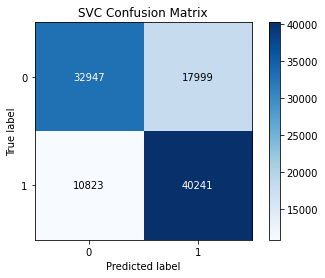

In [33]:
y_pred = svc_calibrated.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/svc_fs3/svc_confusion_matrix.png')

## Logistic Regression

In [23]:
lr_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [24]:
lr_clf = LogisticRegression(penalty='l2', class_weight='balanced', dual=False, max_iter=3000)

In [25]:
lr_clf_search = HalvingGridSearchCV(lr_clf, lr_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [26]:
lr_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   0.5s
[CV 1/1] END ..........................................C=0.1; total time=   1.7s
[CV 1/1] END ..........................................C=1.0; total time=   3.8s
[CV 1/1] END .........................................C=10.0; total time=   7.0s
[CV 1/1] END ........................................C=100.0; total time=  10.8s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END ..........................................C=1.0; total time=  11.9s
[CV 1/1] END ........................................C=100.0; total time=  45.9s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=3000),
                    factor=2, param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x0000024C476A6DC0>,
                    scoring='accuracy', verbose=3)

In [27]:
lr_clf_search.best_params_

{'C': 1.0}

In [28]:
lr_clf_search.best_score_

0.7209401115912786

In [29]:
lr_clf_model = lr_clf_search.best_estimator_

In [30]:
lr_clf_model

LogisticRegression(class_weight='balanced', max_iter=3000)

### Evaluation

Accuracy:  0.7176159200078424
Precision:  0.6892236542319856
Recall:  0.7938273539088203
F1:  0.7378365095833561
ROC AUC:  0.7175276603878494
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     50946
           1       0.69      0.79      0.74     51064

    accuracy                           0.72    102010
   macro avg       0.72      0.72      0.72    102010
weighted avg       0.72      0.72      0.72    102010



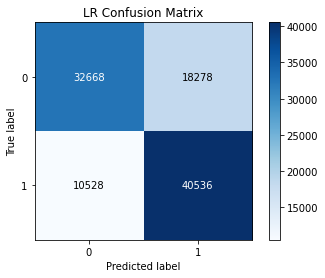

In [31]:
y_pred = lr_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('LR Confusion Matrix')
plt.savefig('graphs/lr_fs3/lr_confusion_matrix.png')

## Random Forest Classifier

In [43]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [44]:
rf_clf = RandomForestClassifier()

In [45]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [46]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 25502
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 25502
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200; total time=  11.7s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500; total time=  29.8s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800; total time=  46.6s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200; total time=  11.0s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500; total time=  28.1s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800; total time=  46.2s
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=200; total time=  11.6s
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=500; total time=  28.8s
[CV 1/1] END max_depth=150, min_samples_split=5,

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=RandomForestClassifier(), factor=2,
                    param_grid={'max_depth': [70, 150, None],
                                'min_samples_split': [5, 15],
                                'n_estimators': [200, 500, 800]},
                    refit=<function _refit_callable at 0x000001689B99F040>,
                    scoring='accuracy', verbose=3)

In [47]:
rf_clf_search.best_params_

{'max_depth': 70, 'min_samples_split': 5, 'n_estimators': 500}

In [48]:
rf_clf_search.best_score_

0.8237235519973858

In [49]:
rf_clf_model = rf_clf_search.best_estimator_

In [50]:
rf_clf_model

RandomForestClassifier(max_depth=70, min_samples_split=5, n_estimators=500)

### Evaluation

Accuracy:  0.8403881972355651
Precision:  0.7948226757984674
Recall:  0.918161522794924
F1:  0.8520517573510703
ROC AUC:  0.8402981288060908
              precision    recall  f1-score   support

           0       0.90      0.76      0.83     50946
           1       0.79      0.92      0.85     51064

    accuracy                           0.84    102010
   macro avg       0.85      0.84      0.84    102010
weighted avg       0.85      0.84      0.84    102010



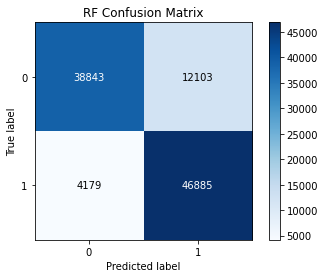

In [51]:
y_pred = rf_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('RF Confusion Matrix')
plt.savefig('graphs/rf_fs3/rf_confusion_matrix.png')

## XGBoost

In [52]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

In [53]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_test)

    logloss = log_loss(y_test, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }

In [54]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [63]:
trials = Trials()
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

Log loss = 0.37172236426801547                                                                                         
Log loss = 0.40652011317189385                                                                                         
Log loss = 0.38899955008453313                                                                                         
Log loss = 0.44923389514458884                                                                                         
Log loss = 0.3870658311449564                                                                                          
100%|█████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.77s/trial, best loss: 0.37172236426801547]


In [64]:
print("Best Param : ", best_param)

Best Param :  {'learning_rate': 0.33, 'max_depth': 5}


#### Training the model with the tuned parameters.

In [65]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 5,
            eta = 0.33
        )

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [59]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [66]:
xgb_model = xgb.train(params, dtrain, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.61066	valid-logloss:0.61116
[10]	train-logloss:0.49021	valid-logloss:0.49300
[20]	train-logloss:0.47613	valid-logloss:0.48028
[30]	train-logloss:0.46813	valid-logloss:0.47350
[40]	train-logloss:0.46272	valid-logloss:0.46936
[50]	train-logloss:0.45821	valid-logloss:0.46601
[60]	train-logloss:0.45449	valid-logloss:0.46342
[70]	train-logloss:0.45129	valid-logloss:0.46115
[80]	train-logloss:0.44839	valid-logloss:0.45945
[90]	train-logloss:0.44564	valid-logloss:0.45793
[100]	train-logloss:0.44313	valid-logloss:0.45641
[110]	train-logloss:0.44044	valid-logloss:0.45491
[120]	train-logloss:0.43779	valid-logloss:0.45308
[130]	train-logloss:0.43601	valid-logloss:0.45215
[140]	train-logloss:0.43401	valid-logloss:0.45132
[150]	train-logloss:0.43130	valid-logloss:0.45007
[160]	train-logloss:0.42882	valid-logloss:0.44868
[170]	train-logloss:0.42678	valid-logloss:0.44778
[180]	train-logloss:0.42467	valid-logloss:0.44676
[190]	train-logloss:0.42278	valid-logloss:0.44585
[200]	train

In [67]:
xgb_clf = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = '5',
                    learning_rate = '0.33',
                )
    
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate='0.33', max_delta_step=0, max_depth='5',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

### Evaluation

Log Loss:  0.43782111547161506
Accuracy:  0.7859327516910107
Precision:  0.7465373260227752
Recall:  0.8665791947360175
F1:  0.8020917354697795
ROC AUC:  0.785839355935904
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     50946
           1       0.75      0.87      0.80     51064

    accuracy                           0.79    102010
   macro avg       0.79      0.79      0.78    102010
weighted avg       0.79      0.79      0.78    102010



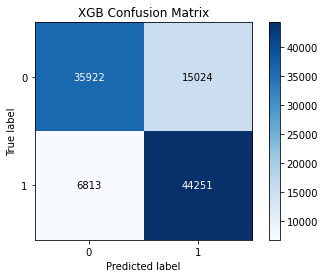

In [68]:
y_predicted_probs = xgb_clf.predict_proba(X_test)

y_pred = xgb_clf.predict(X_test)

print("Log Loss: ", log_loss(y_test, y_predicted_probs))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('XGB Confusion Matrix')
plt.savefig('graphs/xgb_fs3/xgb_confusion_matrix.png')